# House price prediction from Airbnb housing and socio-demographic indexes from New York City, 2017

* Brocco Mattia **|** 873058
* Piccolo Giulio **|** 874727

In [4]:
#import dtale
import os
import statistics
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy
%matplotlib inline

import Data_cleaner as cle
import Cleaner_2 as res
%reload_ext autoreload
%autoreload 2

cleaner = cle.Cleaners()
shaper = res.Reshaper()

In [5]:
### Giulio: "/Users/giuliopiccolo/Desktop/lab/project/dataset/"
### Mattia: ""/Users/matti/Desktop/BA Second Year/3. Lab of Information systems and analytics/3. Project/"

In [6]:
path = os.getcwd() + '\\'
airbnb = pd.read_csv(path + "NYC_Airbnb_2017.csv", low_memory = False)
house_price = pd.read_csv(path + "nyc-rolling-sales.csv")
crashes = pd.read_csv(path + "NYC_collision.csv", low_memory = False)

In [7]:
neighborhoods = pd.read_excel(path + "NYC_neighborhoods.xlsx")
neigh_list = [tuple(x) for x in neighborhoods.values.tolist()]

## Data cleaning of NYC House Price dataset

To assess the proportion to cut off the mean to compute the trimmed mean, we performed this analysis and the graphic result shows how a good approximation can be made at the cutoff of:
* 0.011 for "land_square_feet"
* 0.08 for "gross_square_feet"

```python
# This study was performed during data cleaning operations of the abovementioned dataframe
x_var = np.arange(0, 0.5, 0.001)
y_var = np.array( [round(scipy.stats.trim_mean(df_price['land_square_feet'], x), 3) for x in x_var] )
z_soglia = [1650 for x in range(len(x_var))] # visual check for interception with y_var

plt.figure(figsize=(15,6))
plt.plot(y_var, linewidth = 5, color = "#A4063E")
plt.plot(z_soglia, linewidth = 2, color = "blue")

def find_nearest(array, value):
    """
    * idx is the position (index) of the value we are looking for,
    using the function armin to find the minimum value
    * then return the actual value found
    """
    idx = (np.abs(array - value)).argmin()
    return array[idx]

y_var_list = list(y_var)
x_var_list = list(x_var)

# Visualize the threshold for the truncated mean
print(  x_var_list[y_var_list.index(find_nearest(y_var, z_soglia[0]))]  )
```

## Data cleasing of NYC house prices dataset

In [8]:
df_price = cleaner.house_price_cleaner(house_price)
df_price = df_price[df_price['sale_price'].notna()]
df_price.sale_price = [int(x) for x in df_price.sale_price]
df_price.shape

(83783, 20)

In [9]:
df_price.dtypes

borough                            int64
neighborhood                      object
building_class_category           object
tax_class_at_present              object
block                              int64
lot                                int64
building_class_at_present         object
address                           object
apartment_number                  object
zip_code                           int64
residential_units                  int64
commercial_units                   int64
total_units                        int64
land_square_feet                   int64
gross_square_feet                  int64
year_built                         int64
tax_class_at_time_of_sale          int64
building_class_at_time_of_sale    object
sale_price                         int64
sale_date                         object
dtype: object

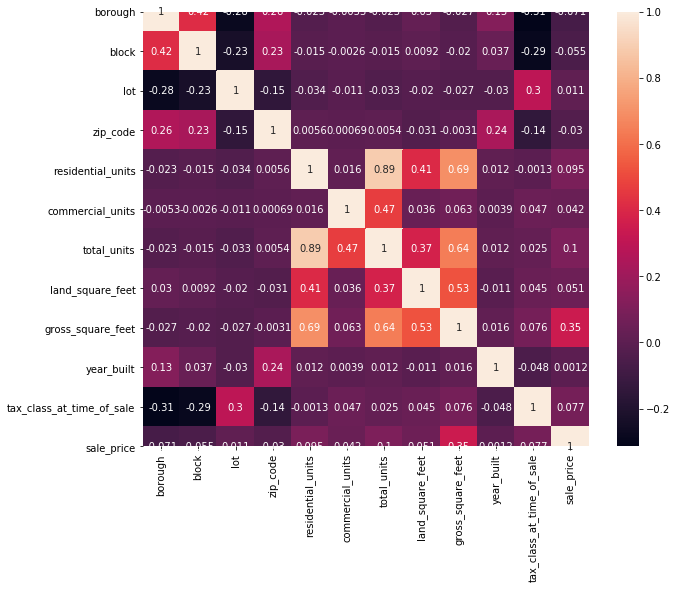

In [10]:
# Heatmap of correlations
plt.figure(figsize = (10,8)); sns.heatmap(df_price.corr(), annot = True)

[100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0, 100.0]


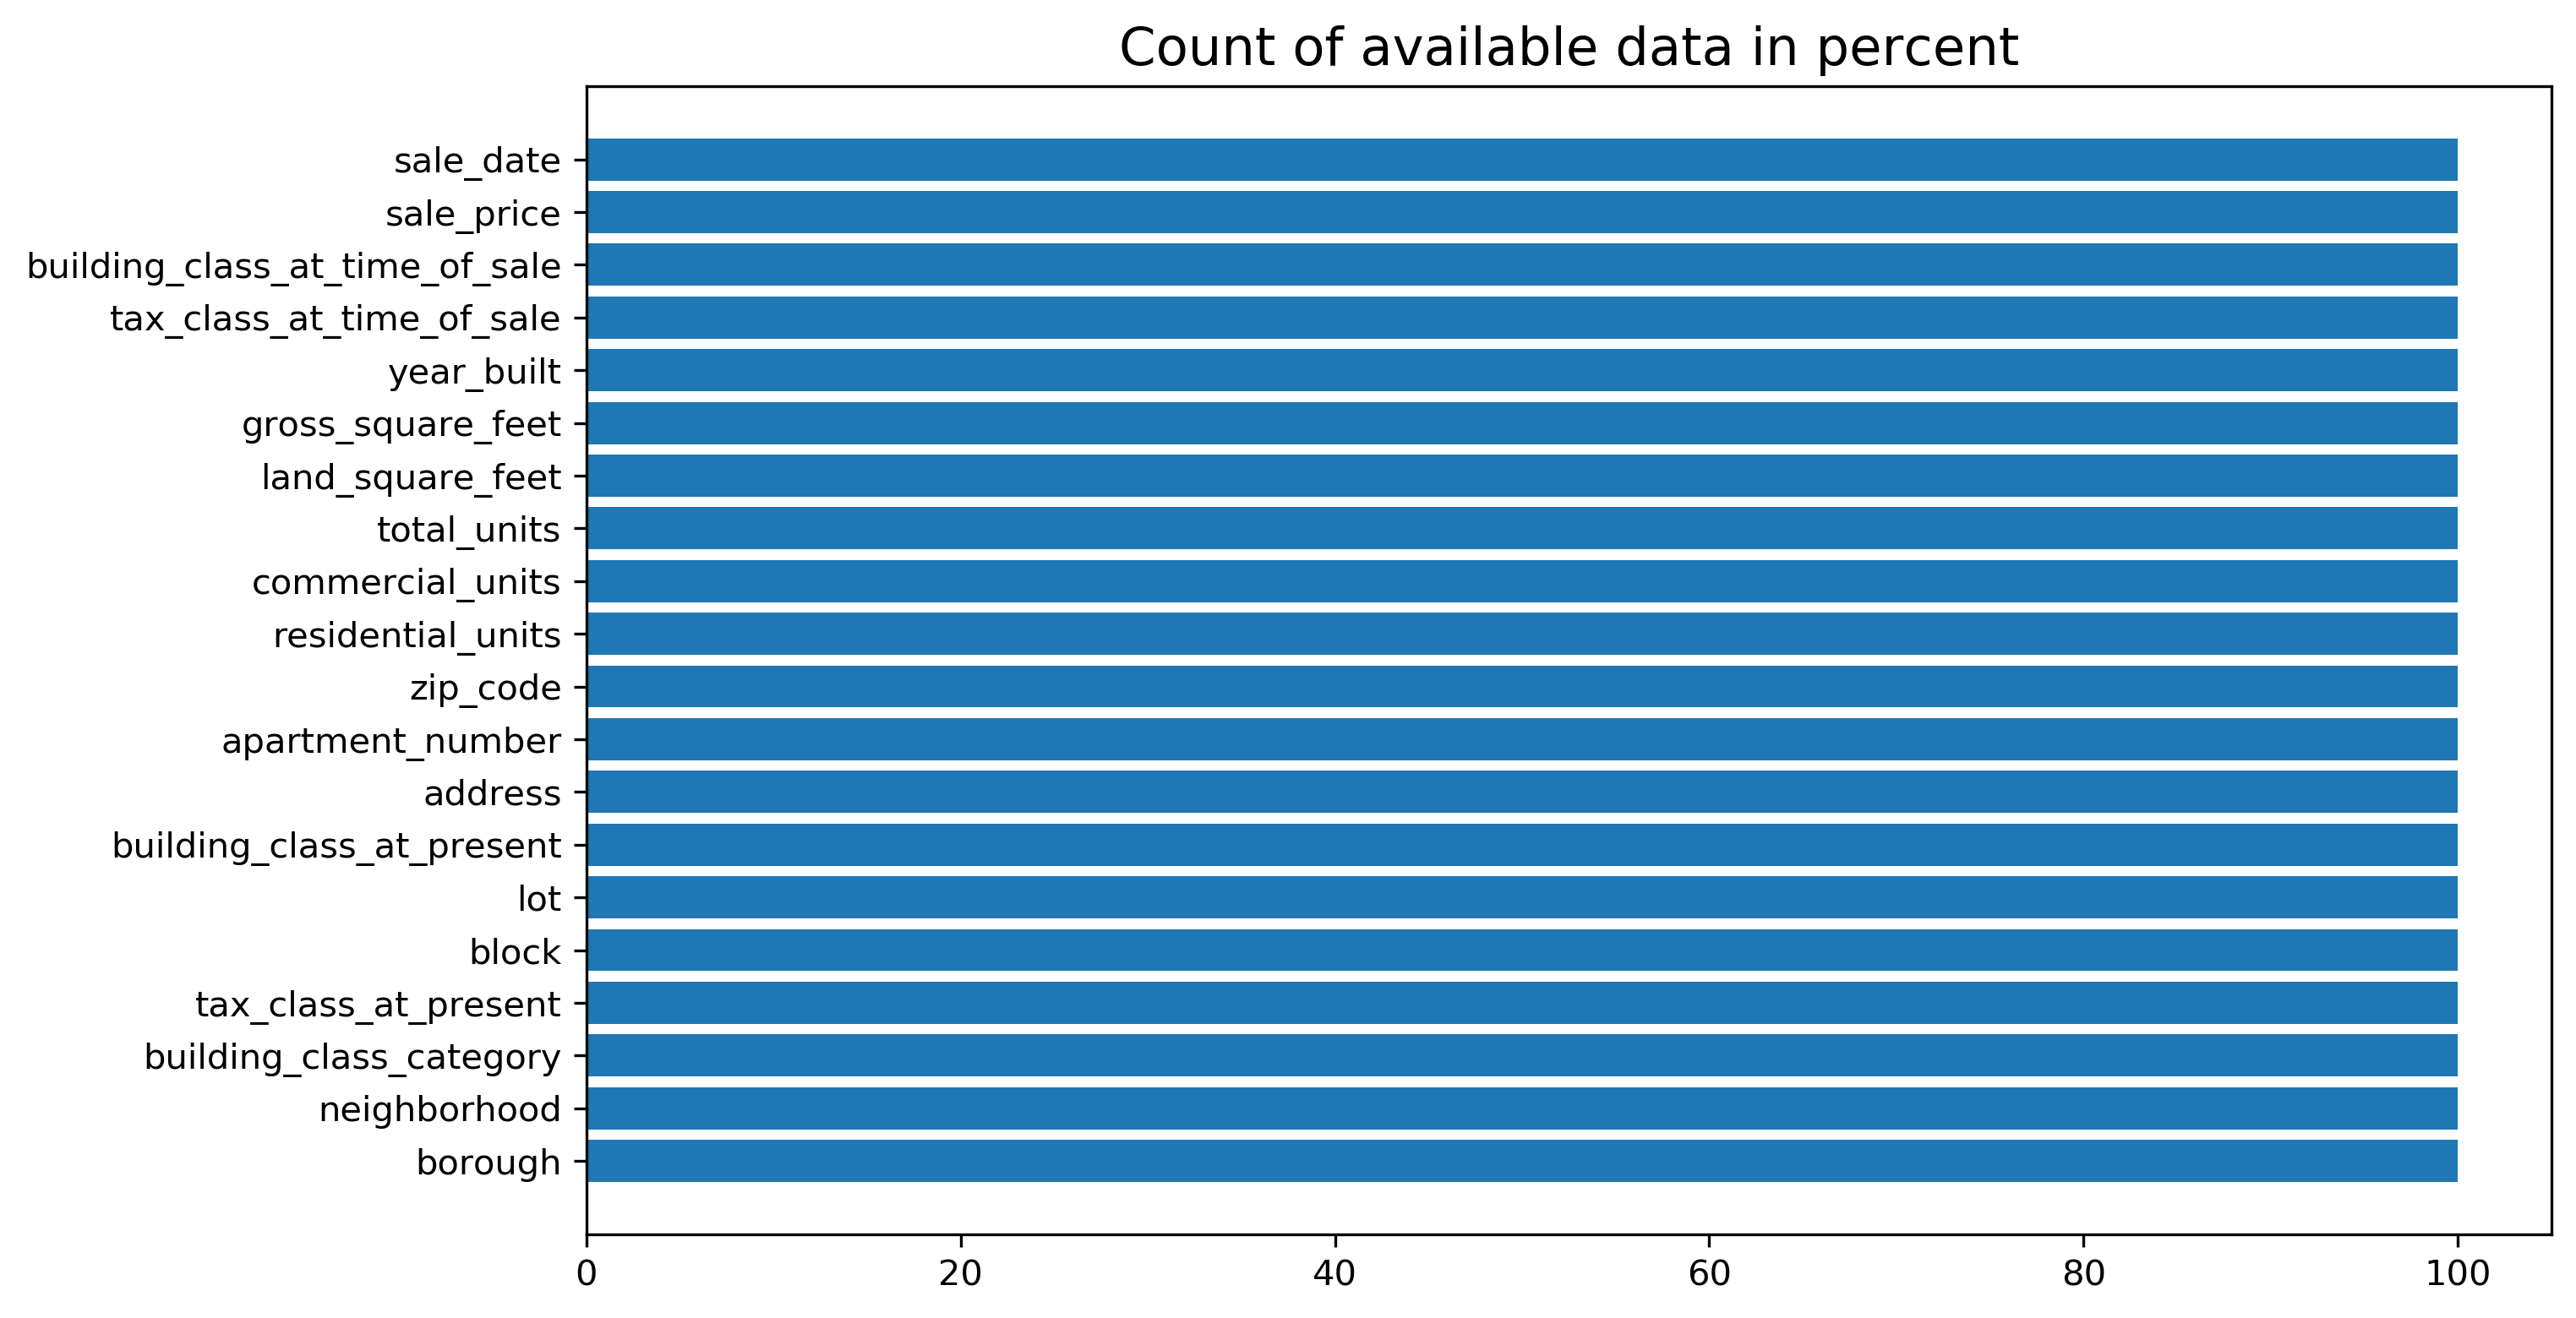

In [11]:
# Barplot of available values
gess = df_price.copy()
count = []
for var in gess.columns:
    length = gess[var].count()
    count.append(length)
    
count_pct = np.round(100 * pd.Series(count) / len(gess), 2)
print(count_pct.tolist())

plt.figure(figsize=(10,6), dpi = 300)
plt.barh(gess.columns, count_pct)
plt.title('Count of available data in percent', fontsize=15)
plt.show()

## Data cleasing of NYC car accidents dataset

In [12]:
df_crash = cleaner.crash_cleaner(crashes, neigh_list)
df_crash.shape

(204908, 25)

### How many missing values do we have?

The following heatmap serves as a way to visualize the extent to which a column contains empty cells.
- Crashes that involve more than 2 vehicles are higly populated of missing values as expected, since most of the time crashes involves two vehicles only
- The 'borough' column needs to be improved, and we did it by gathering the coordinates of the accident to identify the borough name

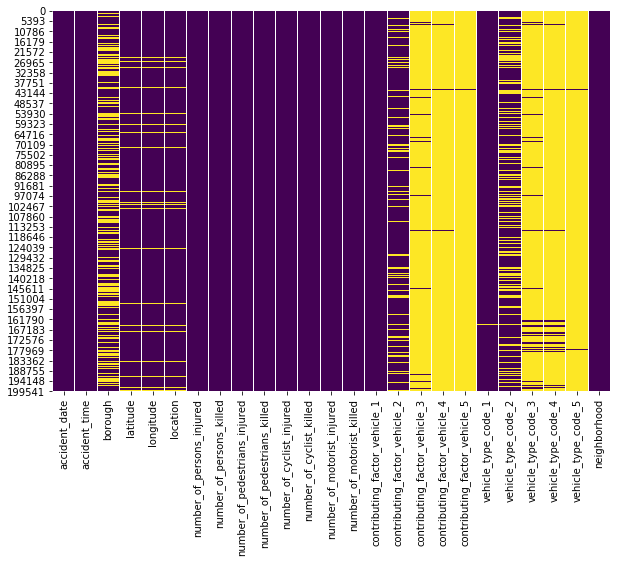

In [13]:
crash_to_viz = df_crash.copy()
plt.figure(figsize=(10,7))
sns.heatmap(crash_to_viz.isnull(), cbar = False, cmap = 'viridis')

In [14]:
from math import cos, asin, sqrt
# Haversine formula
def distance_viz(lat1, lon1, lat2, lon2):
    p = 0.017453292519943295 # math.PI / 180
    a = 0.5 - cos((lat2-lat1)*p)/2 + cos(lat1*p)*cos(lat2*p) * (1-cos((lon2-lon1)*p)) / 2
    return 12742 * asin(sqrt(a)) #2 * R; R = 6371 km

# get the closest point 
def closest_viz(data, v):
    return min(data, key = lambda p: distance_viz(v[0], v[1], p[0], p[1]) )

borough_dict = {"BRONX" : [40.837048, -73.865433], "BROOKLYN" : [40.650002, -73.949997],
                "MANHATTAN" : [40.758896, -73.985130], "QUEENS" : [40.742054,-73.769417],
                "STATEN ISLAND" : [40.579021,-74.151535]}

boroughs = [(*value, key) for key, value in borough_dict.items()]

crash_to_viz['borough'] = crash_to_viz.apply( lambda row:
    closest_viz(boroughs, [row['latitude'], row['longitude']])[2]
    if row['borough'] is None else row['borough'], axis=1)

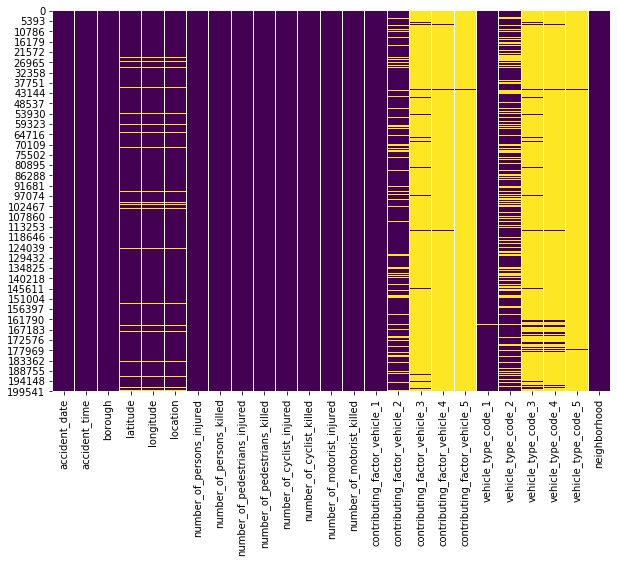

In [15]:
# The same heatmap is performed to check the quantity of NaN values after the abovementioned map has been applied
plt.figure(figsize=(10,7))
sns.heatmap(crash_to_viz.isnull(), cbar = False, cmap = 'viridis')

## Data cleasing of Airbnbs of NYC dataset
The "airbnb" dataframe required only a little effort in cleasing operations. As shown through the chunck below, which output is $2.741 \% $, this dataset is characterized by a very low rate of empty cells.
```python
print("Missing values: ",  df_blocks.isnull().sum().sum() , " | Perc of total: ",
      round(100*df_blocks.isnull().sum().sum() / (df_blocks.shape[0]*df_blocks.shape[1]), 3))
```
So, we decided to all drop the rows that presented NaN values, since they represent only a small share of the total.

```python
total = df1.isnull().sum().sort_values(ascending = False)
percent = (df1.isnull().sum()/df1.isnull().count()).sort_values(ascending = False)

missing_data = pd.concat([total, percent], axis = 1, keys = ['NAs', 'Percent']) # df with columns, nan values and %
plt.plot( missing_data['Percent'] )
missing_data.drop(missing_data[missing_data.Percent < 0.2].index, inplace = True)
```
After a further evaluation of the columns, we assessed that only ```"reviews_per_month"``` and ```"last_review"``` had more than more than 20% of the whole column filled with NaN values. So, we dropped those two columns and used ```.dropna()``` to delete other few rows with any NaN values.

In [16]:
df_airbnb = cleaner.airbnb_cleaner(airbnb, neigh_list)
df_airbnb.shape

True


(48486, 14)

## NYC Neighborhoods coordinates and neigborhoods applied to all dataframes

The following code was used to create the dataset
```python
# !!!!!!!! DA SISTEMARE PER CREDIBILITA' (FOR CON LISTE E OUTPUT E' UN DATAFRAME)
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="project_lisa")
location = geolocator.geocode("West Harlem")
print((location.latitude, location.longitude))
```

## Merge of all datasets

Il dataset che dobbiamo ottenere ha come riga una casa, le colonne riguardanti gli incidenti e gli airbnb sono mergate rispetto al quartiere di appartenenza della casa.
- ogni dataset va trasformato (tipo pivot) in modo che abbia come riga un quartiere e come colonna degli "aggregate" per ogni quartiere
- poi si fa un merge degli altri due addosso a df_price (che di suo avrà già le coordinate latitudine e longitudine)

ES: Airbnb
- drop delle colonne "id","name","host_id","host_name","borough"
- COLONNE: Neighborhood, Moda di romm_type, media di price, media di min_price, media di reviews, media di listings, media di availability /// RIGHE: tante quante sono i quartieri

ES: Crash
- drop delle colonne "accident_date", "accident_time", "borough", "location", tutte quelle con 1-2-3-4-5
- COLONNE: Neighborhood, media di persons injured, media di persons killed, media di number_of_pedestrians_injured, media di number_of_pedestrians_killed, media di number_of_cyclist_injured, media di number_of_cyclist_killed, media di number_of_motorist_injured, media di number_of_motorist_killed

Tutte le abitazione nello stesso quartiere avranno le stesse informazioni rispetto agli airbnb.

In [17]:
crash_pivot = shaper.PVT_crash(df_crash)
crash_pivot.shape

(235, 9)

In [18]:
bnb_pivot = shaper.PVT_bnb(df_airbnb)
bnb_pivot.shape

(218, 7)

In [19]:
merge_fun = shaper.merger(df_price, bnb_pivot)
merge_finale = shaper.merger(merge_fun, crash_pivot)
merge_finale.shape

(83783, 34)

In [20]:
copia_fin = merge_finale.copy()
copia_fin = copia_fin.dropna()
copia_fin = copia_fin.reset_index(drop = True)
copia_fin.shape

(74303, 34)

In [21]:
copia_prova = copia_fin.copy()
copia_prova.drop(copia_prova[copia_prova.building_class_category == '05 TAX CLASS 1 VACANT LAND                 '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '06 TAX CLASS 1 - OTHER                     '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '14 RENTALS - 4-10 UNIT                     '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '15 CONDOS - 2-10 UNIT RESIDENTIAL          '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '16 CONDOS - 2-10 UNIT WITH COMMERCIAL UNIT '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '21 OFFICE BUILDINGS                        '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '22 STORE BUILDINGS                         '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '25 LUXURY HOTELS                           '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '26 OTHER HOTELS                            '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '27 FACTORIES                               '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '28 COMMERCIAL CONDOS                       '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '29 COMMERCIAL GARAGES                      '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '30 WAREHOUSES                              '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '31 COMMERCIAL VACANT LAND                  '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '32 HOSPITAL AND HEALTH FACILITIES          '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '33 EDUCATIONAL FACILITIES                  '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '34 THEATRES                                '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '35 INDOOR PUBLIC AND CULTURAL FACILITIES   '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '36 OUTDOOR RECREATIONAL FACILITIES         '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '37 RELIGIOUS FACILITIES                    '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '39 TRANSPORTATION FACILITIES               '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '40 SELECTED GOVERNMENTAL FACILITIES        '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '41 TAX CLASS 4 - OTHER                     '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '42 CONDO CULTURAL/MEDICAL/EDUCATIONAL/ETC  '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '44 CONDO PARKING                           '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '45 CONDO HOTELS                            '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '46 CONDO STORE BUILDINGS                   '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '47 CONDO NON-BUSINESS STORAGE              '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '48 CONDO TERRACES/GARDENS/CABANAS          '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '49 CONDO WAREHOUSES/FACTORY/INDUS          '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '18 TAX CLASS 3 - UNTILITY PROPERTIES       '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '43 CONDO OFFICE BUILDINGS                  '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '04 TAX CLASS 1 CONDOS                      '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '38 ASYLUMS AND HOMES                       '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '23 LOFT BUILDINGS                          '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '17 CONDO COOPS                             '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '11A CONDO-RENTALS                           '].index,inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '12 CONDOS - WALKUP APARTMENTS              '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '07 RENTALS - WALKUP APARTMENTS             '].index, inplace = True)
copia_prova.drop(copia_prova[copia_prova.building_class_category == '08 RENTALS - ELEVATOR APARTMENTS           '].index, inplace = True)

copia_prova

,borough,neighborhood,building_class_category,tax_class_at_present,block,lot,building_class_at_present,address,apartment_number,zip_code,...,price,room_type,number_of_cyclist_injured,number_of_cyclist_killed,number_of_motorist_injured,number_of_motorist_killed,number_of_pedestrians_injured,number_of_pedestrians_killed,number_of_persons_injured,number_of_persons_killed
12,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,...,168.08232,Entire home/apt,0.023984,0.000076,0.208753,0.00084,0.034143,0.000687,0.267206,0.001604
13,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 1C",,10009,...,168.08232,Entire home/apt,0.023984,0.000076,0.208753,0.00084,0.034143,0.000687,0.267206,0.001604
14,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 3A",,10009,...,168.08232,Entire home/apt,0.023984,0.000076,0.208753,0.00084,0.034143,0.000687,0.267206,0.001604
15,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3RD STREET, 5A",,10009,...,168.08232,Entire home/apt,0.023984,0.000076,0.208753,0.00084,0.034143,0.000687,0.267206,0.001604
16,1,ALPHABET CITY,09 COOPS - WALKUP APARTMENTS,2,373,40,C6,"327 EAST 3 STREET, 2E",,10009,...,168.08232,Entire home/apt,0.023984,0.000076,0.208753,0.00084,0.034143,0.000687,0.267206,0.001604
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
74296,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7317,126,B2,112 ROBIN COURT,,10309,...,225.00000,Private room,0.045455,0.000000,0.227273,0.00000,0.045455,0.000000,0.318182,0.000000
74297,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7339,41,B9,41 SONIA COURT,,10309,...,225.00000,Private room,0.045455,0.000000,0.227273,0.00000,0.045455,0.000000,0.318182,0.000000
74298,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,34,B9,37 QUAIL LANE,,10309,...,225.00000,Private room,0.045455,0.000000,0.227273,0.00000,0.045455,0.000000,0.318182,0.000000
74299,5,WOODROW,02 TWO FAMILY DWELLINGS,1,7349,78,B9,32 PHEASANT LANE,,10309,...,225.00000,Private room,0.045455,0.000000,0.227273,0.00000,0.045455,0.000000,0.318182,0.000000


---
---